In [42]:
# inspired and data from: kaggle.com/code/shivamb
# https://www.kaggle.com/datasets/aashita/nyt-comments?resource=download

In [44]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt

In [9]:
files_list = glob.glob("./NY_data/Ar*")

In [10]:
files_list

['./NY_data/ArticlesMay2017.csv',
 './NY_data/ArticlesApril2018.csv',
 './NY_data/ArticlesApril2017.csv',
 './NY_data/ArticlesJan2018.csv',
 './NY_data/ArticlesFeb2017.csv',
 './NY_data/ArticlesJan2017.csv',
 './NY_data/ArticlesFeb2018.csv',
 './NY_data/ArticlesMarch2017.csv',
 './NY_data/ArticlesMarch2018.csv']

In [25]:
corpus = []
for file in files_list:
    _df = pd.read_csv(file)
    corpus.extend(list(_df["headline"].values))

In [26]:
corpus[:10]

['My Beijing: The Sacred City',
 '6 Million Riders a Day, 1930s Technology',
 'Seeking a Cross-Border Conference',
 'Questions for: ‘Despite the “Yuck Factor,” Leeches Are Big in Russian Medicine’',
 'Who Is a ‘Criminal’?',
 'An Antidote to Europe’s Populism',
 'The Cost of a Speech',
 'Degradation of the Language',
 'On the Power of Being Awful',
 'Trump Garbles Pitch on a Revised Health Bill']

In [27]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

input_sequences, total_words = get_sequence_of_tokens(corpus)
input_sequences[:10]

[[53, 1617],
 [53, 1617, 1],
 [53, 1617, 1, 1993],
 [53, 1617, 1, 1993, 126],
 [127, 347],
 [127, 347, 1994],
 [127, 347, 1994, 2],
 [127, 347, 1994, 2, 122],
 [127, 347, 1994, 2, 122, 2515],
 [127, 347, 1994, 2, 122, 2515, 823]]

In [29]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [31]:
X, y = input_sequences[:,:-1],input_sequences[:,-1]

In [32]:
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

In [37]:
input_len = max_sequence_len - 1

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=total_words, output_dim=10, input_length=input_len))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 27, 10)            117530    
                                                                 
 lstm_3 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 11753)             1187053   
                                                                 
Total params: 1348983 (5.15 MB)
Trainable params: 1348983 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
cb = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)]

In [40]:
hist = model.fit(X, y, epochs=100, callbacks=cb)

Epoch 1/100
1666/1666 [==============================] - 31s 18ms/step - loss: 7.8897
Epoch 2/100
1666/1666 [==============================] - 29s 17ms/step - loss: 7.4817
Epoch 3/100
1666/1666 [==============================] - 30s 18ms/step - loss: 7.2910
Epoch 4/100
1666/1666 [==============================] - 30s 18ms/step - loss: 7.0716
Epoch 5/100
1666/1666 [==============================] - 30s 18ms/step - loss: 6.8399
Epoch 6/100
1666/1666 [==============================] - 29s 18ms/step - loss: 6.6010
Epoch 7/100
1666/1666 [==============================] - 31s 19ms/step - loss: 6.3515
Epoch 8/100
1666/1666 [==============================] - 30s 18ms/step - loss: 6.1023
Epoch 9/100
1666/1666 [==============================] - 29s 18ms/step - loss: 5.8596
Epoch 10/100
1666/1666 [==============================] - 29s 18ms/step - loss: 5.6346
Epoch 11/100
1666/1666 [==============================] - 30s 18ms/step - loss: 5.4140
Epoch 12/100
1666/1666 [============================

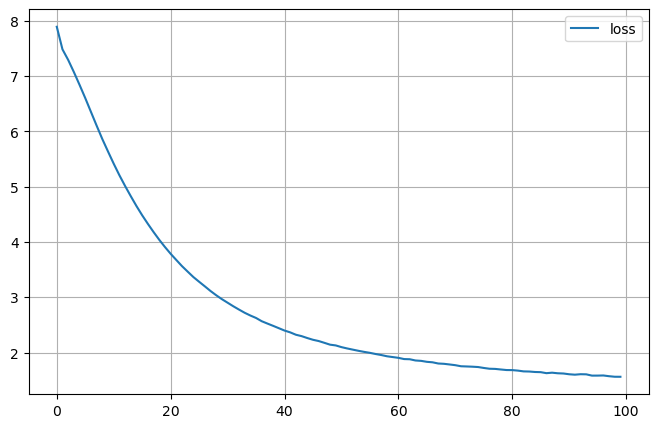

In [49]:
pd.DataFrame(hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [50]:
model.save("./txt_gen.h5")

/root/miniconda3/envs/env2/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generate text

In [54]:
def generate_text(seed_txt, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_txt])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_txt += " " + output_word 
    print(seed_txt)

In [56]:
generate_text("united states", 5, model, max_sequence_len)

united states gets too putin to lead


In [58]:
generate_text("New", 5, model, max_sequence_len)

New york today a makeshift law


In [61]:
generate_text("there was", 10, model, max_sequence_len)

there was more racial act behind travel friends and trump in silicon
